# Week 7, Lecture 14 Exercise

In [1]:
# imports
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy.stats import shapiro, bartlett
from matplotlib import pyplot as plt
import pandas

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf

import pymannkendall as mk

# Changepoint software for Python

## https://github.com/deepcharles/ruptures

## https://github.com/shunsukeaihara/changefinder

----

# Exercise

## Load data

In [4]:
df = pandas.read_csv('../Data/PM25West.csv')
df.head()

,Year,Mean
0,2000,14.081182
1,2001,14.428510
2,2002,14.950187
3,2003,12.644606
4,2004,12.244171


## Index

In [5]:
df.set_index('Year', inplace=True)
df.head()

,Mean
Year,
2000,14.081182
2001,14.428510
2002,14.950187
2003,12.644606
2004,12.244171


## Plot

<AxesSubplot:xlabel='Year'>

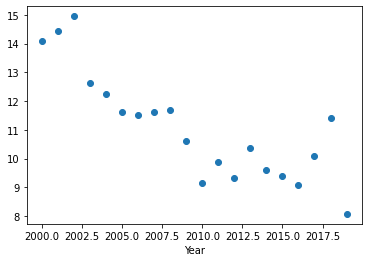

In [8]:
df.Mean.plot(marker='o', ls='')

## Fit a simple linear trend

In [9]:
time = np.arange(len(df)) + 1
df['time'] = time

In [11]:
formula = "Mean ~ time"
mod_ols = smf.glm(formula=formula, data=df).fit()#, family=sm.families.Binomial()).fit()
mod_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   Mean   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          1.0735
Method:                          IRLS   Log-Likelihood:                -28.035
Date:                Wed, 11 May 2022   Deviance:                       19.324
Time:                        10:03:37   Pearson chi2:                     19.3
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8986
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.9398      0.481     28.962      0.000      12.996      14.883
time          -0.2715      0.040     -6.758      0.000      -0.350      -0.193
==============================================================================
"""

In [12]:
mod_ols.pvalues

Intercept    1.975574e-184
time          1.399374e-11
dtype: float64

## Examine Residuals

### Independence?

In [13]:
resids = df.Mean-mod_ols.fittedvalues

In [14]:
durbin_watson(resids)

1.253820752322077

#### Suggestive of some autocorrelation, let's check!

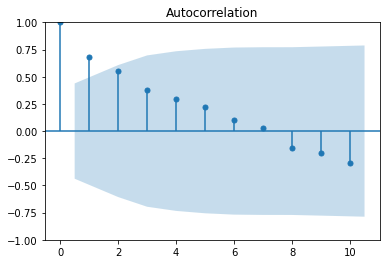

In [15]:
_ = plot_acf(df.Mean.values, lags=10)#, ax=ax)

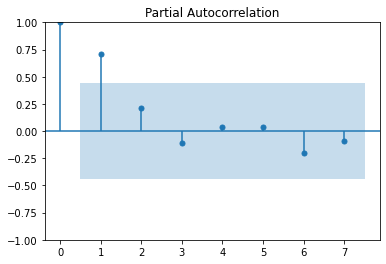

In [19]:
_ = plot_pacf(df.Mean.values, lags=7)#, ax=ax)

#### Yes, we find evidence for a correlation.  Let's proceed accordingly

## Generalized LS Fit

In [31]:
endog = pandas.DataFrame()
endog['time'] = time
endog['intercept'] = 1.

In [32]:
glsar_model = sm.GLSAR(df.Mean.values, endog, 1)
glsar_results = glsar_model.iterative_fit(15)
glsar_results.summary()

/home/xavier/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.481
Model:                          GLSAR   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     15.73
Date:                Wed, 11 May 2022   Prob (F-statistic):           0.000998
Time:                        10:17:03   Log-Likelihood:                -25.646
No. Observations:                  19   AIC:                             55.29
Df Residuals:                      17   BIC:                             57.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
time          -0.2645      0.067     -3.966      0.001      -0.405      -0.124
intercept     13.8092      0.856     16.125      0.000      12.002      15.616
==============================================================================
Omnibus:                        1.830   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.401   Jarque-Bera (JB):                1.003
Skew:                           0.563   Prob(JB):                        0.606
Kurtosis:                       2.992   Cond. No.                         30.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
glsar_results.aic

55.29159866262245

In [36]:
mod_ols.aic

60.06970969187513

## We find a lower AIC for the GLS model with AR(1) and are inclined to adopt this model

## Examine the new residuals

In [37]:
gls_resids = df.Mean.values - glsar_results.fittedvalues

### Shapiro-Watson

In [38]:
shapiro(gls_resids)

ShapiroResult(statistic=0.9210602045059204, pvalue=0.10385347902774811)

### Acceptible (barely)

## Plot